In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [7]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [8]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

INFO:tensorflow:Using /var/folders/wm/2s8_xkjx7jx1hd1w2svmn5kh0000gn/T/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 38.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 68.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 98.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 128.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 158.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 188.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 218.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 248.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-se

In [9]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

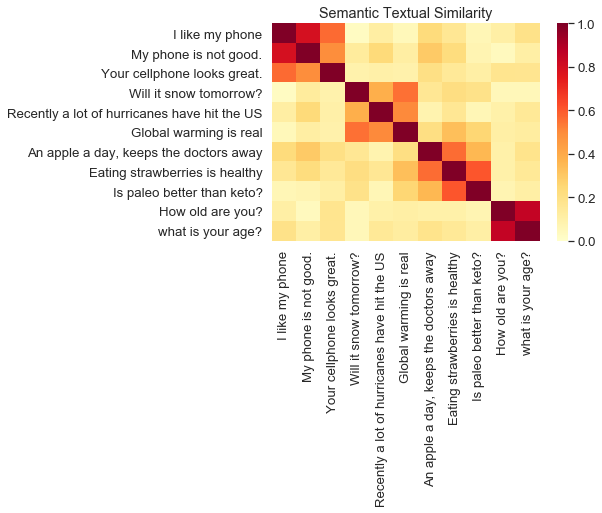

In [10]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)

In [11]:
import pandas
import scipy
import math


def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
  sent_pairs = []
  with tf.gfile.GFile(filename, "r") as f:
    for line in f:
      ts = line.strip().split("\t")
      # (sent_1, sent_2, similarity_score)
      sent_pairs.append((ts[5], ts[6], float(ts[4])))
  return pandas.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

  sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
  sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

  return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()

417792/409630 [==============================] - 1s 3us/step


In [12]:
sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1), axis=1)
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2), axis=1)
cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
sim_scores = 1.0 - tf.acos(clip_cosine_similarities)

In [13]:
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

In [14]:
text_a = sts_data['sent_1'].tolist()
text_b = sts_data['sent_2'].tolist()
dev_scores = sts_data['sim'].tolist()

def run_sts_benchmark(session):
  """Returns the similarity scores"""
  emba, embb, scores = session.run(
      [sts_encode1, sts_encode2, sim_scores],
      feed_dict={
          sts_input1: text_a,
          sts_input2: text_b
      })
  return scores


with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.7629205501666685
p-value = 4.521539751346317e-286
